In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.1 MB/s eta 0:00:00


In [71]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier

from model_tools import woe_stab, woe_line, plot_metric_time, crosstab
from lightgbm import plot_importance, plot_metric

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузим датасет

Наша выборка пополнилась новыми признаками!

In [111]:
df = pd.read_csv('/content/drive/MyDrive/Colab Data/df_seminar_boosting_hw.csv')

# техническое поле - месяц прихода заявки в систему
df['month_dt'] = df['crm_income_dt'].astype('datetime64[M]')
df.drop('active_cl_flg', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194366 entries, 0 to 194365
Data columns (total 51 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   application_rk                194366 non-null  int64         
 1   crm_income_dt                 194366 non-null  object        
 2   request_amt                   54418 non-null   float64       
 3   bki_flg                       194366 non-null  int64         
 4   due_chance                    159377 non-null  float64       
 5   due_chance_v02                159377 non-null  float64       
 6   balance_sum                   159377 non-null  float64       
 7   mfo_flg                       159377 non-null  float64       
 8   num_fresh_mfo                 159377 non-null  float64       
 9   num_status_no_due             159377 non-null  float64       
 10  no_ever_due_flg               159377 non-null  float64       
 11  num_closed_cr

In [107]:
df['application_rk']

0              0
1              1
2              2
3              3
4              4
           ...  
194361    194361
194362    194362
194363    194363
194364    194364
194365    194365
Name: application_rk, Length: 194366, dtype: int64

In [26]:
feature_names = list(df.columns)

# удаляем технические поля, таргет
feature_names.remove('application_rk')
feature_names.remove('d4p12')
feature_names.remove('month_dt')
feature_names.remove('crm_income_dt')

In [27]:
test_mask = (df.month_dt >= '2019-07-01') & (df.month_dt <= '2019-12-01')
validation_mask = (df.month_dt >= '2019-05-01') & (df.month_dt <= '2019-06-01')

df['sample_part'] = 'Train'
df.loc[validation_mask, 'sample_part'] = 'Validation'
df.loc[test_mask, 'sample_part'] = 'Test'

df['sample_part'].value_counts()

Train         116151
Test           61299
Validation     16916
Name: sample_part, dtype: int64

In [28]:
# анализ IV : IV < 0.01 - не обладает прогностической способностью;
weak_features = []
for feature_name in feature_names:
  display(Markdown('<h2>' + feature_name + '<h2>'))
  col_type = df[feature_name].dtype
  if col_type != 'object':
    res = woe_line(
    var=df.loc[df.sample_part == 'Train'][feature_name],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm=feature_name,
    target_nm='d4p12',
    plot_line=False,
    plot_hist=False
    )
    if res['IV'] < 0.01:
      feature_names.remove(feature_name)
      weak_features.append(feature_name)
      
weak_features

<h2>request_amt<h2>

Удалено 78823 строк с нуллами, осталось 37328
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
 Wrong objects for 97400: total 1, target 0
 Wrong objects for 99000: total 1, target 0
 Wrong objects for 100440: total 1, target 1
 Wrong objects for 101000: total 1, target 1
 Wrong objects for 105000: total 2, target 0
 Wrong objects for 107000: total 1, target 0
 Wrong objects for 108000: total 1, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>bki_flg<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>due_chance<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>due_chance_v02<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>balance_sum<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>mfo_flg<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_fresh_mfo<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_status_no_due<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>no_ever_due_flg<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_closed_credits<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>no_due_and_short_history_flg<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>outstanding_rate<h2>

Удалено 41722 строк с нуллами, осталось 74429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_month_to_due<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>debt_to_income<h2>

Удалено 22429 строк с нуллами, осталось 93722


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>payments_6month_part<h2>

Удалено 75859 строк с нуллами, осталось 40292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>outstanding_raise<h2>

Удалено 41181 строк с нуллами, осталось 74970


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>fresh_due_flg<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>max_due_status_4_month<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
 Wrong objects for 8: total 1, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_active_credits<h2>

Удалено 21717 строк с нуллами, осталось 94434
 Wrong objects for [14; 20]: total 3, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_bad_debts<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
 Wrong objects for 2: total 1, target 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>max_actual_due_status<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
 Wrong objects for 3: total 2, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>credits_with_due_rate<h2>

Удалено 50239 строк с нуллами, осталось 65912


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>worst_dlq_cd<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>ccr_utilization_rate<h2>

Удалено 59896 строк с нуллами, осталось 56255


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>one_good_credit_flg<h2>

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>outstanding_raise_ccr<h2>

Удалено 75138 строк с нуллами, осталось 41013


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>avg_ann_repay_amt<h2>

Удалено 44365 строк с нуллами, осталось 71786


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>gender_cd<h2>

<h2>age<h2>

Удалено 2437 строк с нуллами, осталось 113714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>marital_status_cd<h2>

<h2>education_level_cd<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>work_exp_cd<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>car_own_flg<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>region_rating<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>job_type_cd<h2>

<h2>debet_score<h2>

Удалено 87202 строк с нуллами, осталось 28949


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_rejected_appl<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>had_cl_flg<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>partner1_score<h2>

Удалено 26015 строк с нуллами, осталось 90136


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>partner2_score<h2>

Удалено 32431 строк с нуллами, осталось 83720


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>telecom1_score<h2>

Удалено 94705 строк с нуллами, осталось 21446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>telecom2_score<h2>

Удалено 23867 строк с нуллами, осталось 92284


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


['no_due_and_short_history_flg',
 'num_bad_debts',
 'one_good_credit_flg',
 'had_cl_flg']

In [29]:
# Анализ стабильности по WOE и распределению
for feature_name in feature_names:
  display(Markdown('<h2>' + feature_name + '<h2>'))
  woe_stab(
    var=df[feature_name],
    Nvar=2,
    time=df['month_dt'],
    bad=df['d4p12'],
    varname=feature_name,
    target='d4p12'
)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# удаляем нестабильные
unstab_features = ['request_amt', 'debt_to_income', 'raise_num_opened_credits', 'bki_flg', 'age', 'num_active_credits']

for unstab_feature_name in unstab_features:
  feature_names.remove(unstab_feature_name)
feature_names

['due_chance',
 'due_chance_v02',
 'balance_sum',
 'mfo_flg',
 'num_fresh_mfo',
 'num_status_no_due',
 'no_ever_due_flg',
 'num_closed_credits',
 'outstanding_rate',
 'num_month_to_due',
 'payments_6month_part',
 'outstanding_raise',
 'fresh_due_flg',
 'max_due_status_4_month',
 'n_actual_delq',
 'max_actual_due_status',
 'credits_with_due_rate',
 'worst_dlq_cd',
 'ccr_utilization_rate',
 'mortgage_flg',
 'outstanding_raise_ccr',
 'avg_ann_repay_amt',
 'gender_cd',
 'marital_status_cd',
 'education_level_cd',
 'work_exp_cd',
 'car_own_flg',
 'region_rating',
 'job_type_cd',
 'debet_score',
 'num_rejected_appl',
 'bki_score',
 'partner1_score',
 'partner2_score',
 'telecom1_score',
 'telecom2_score']

In [31]:
# приведем категориальные фичи к одному типу данных для внедрения в модель
for feature_name in feature_names:
    col_type = df[feature_name].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[feature_name] = df[feature_name].astype('category')

<ipython-input-38-ac2cb4e23f19>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.loc[df.sample_part == 'Train', feature_names].corr()


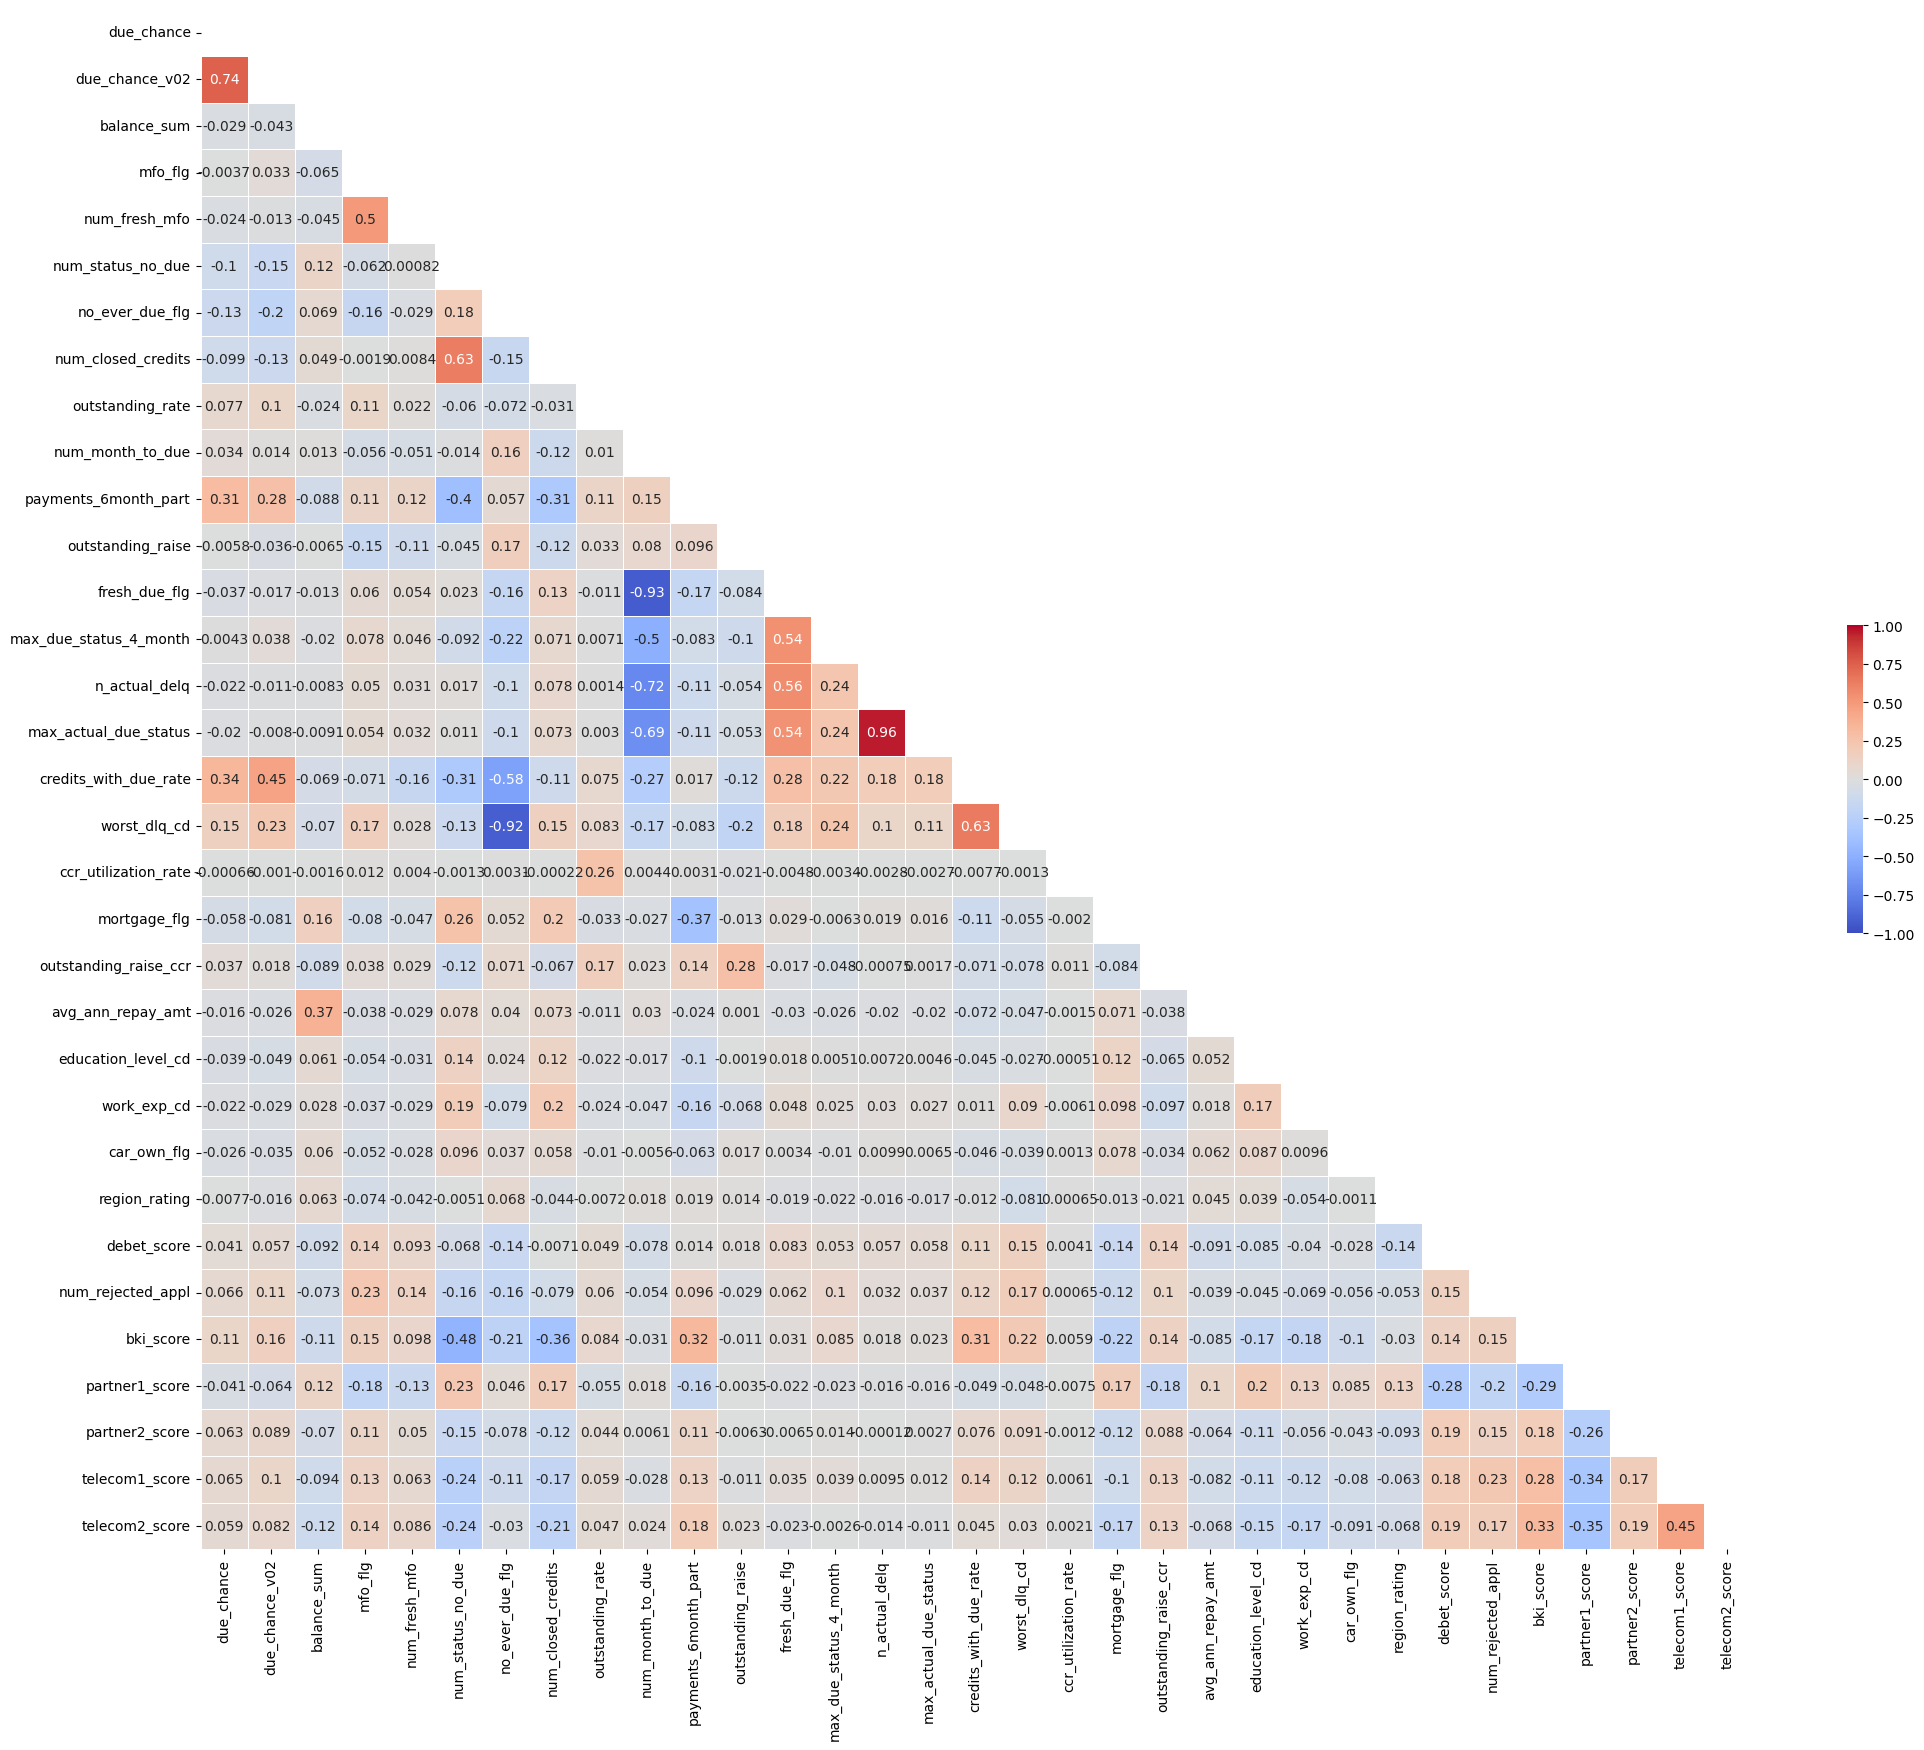

In [38]:
# матрица корреляций 

corr = df.loc[df.sample_part == 'Train', feature_names].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            linewidths=.5, cbar_kws={"shrink": .2})
plt.show()

nbuck=5 for no_ever_due_flg reduced to 4
nbuck=4 for no_ever_due_flg reduced to 3
nbuck=3 for no_ever_due_flg reduced to 2


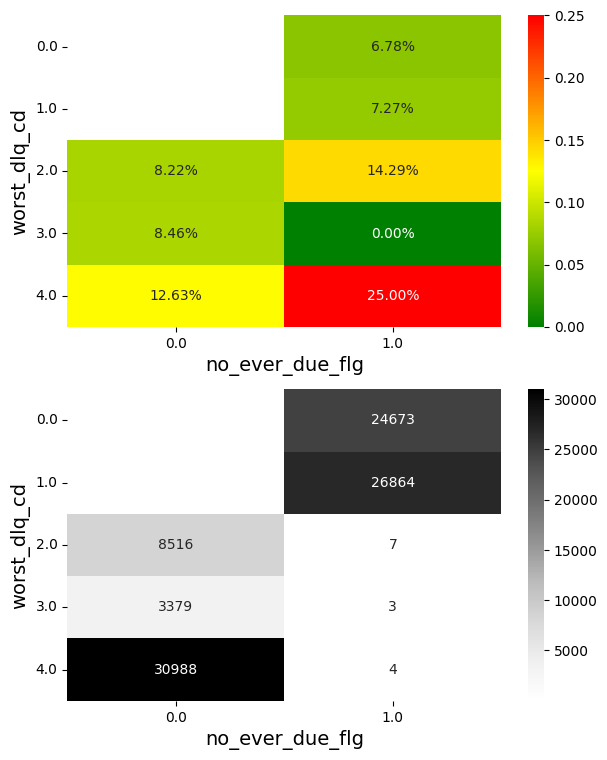

In [48]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['worst_dlq_cd'],
    var_2=df.loc[df.sample_part == 'Train']['no_ever_due_flg'],
    target='d4p12',
    name_1='worst_dlq_cd',
    name_2='no_ever_due_flg',
    nbuck_1=5,
    nbuck_2=5,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)

feature_names.remove('no_ever_due_flg')

nbuck=5 for fresh_due_flg reduced to 4
nbuck=4 for fresh_due_flg reduced to 3
nbuck=3 for fresh_due_flg reduced to 2
nbuck=5 for num_month_to_due reduced to 4


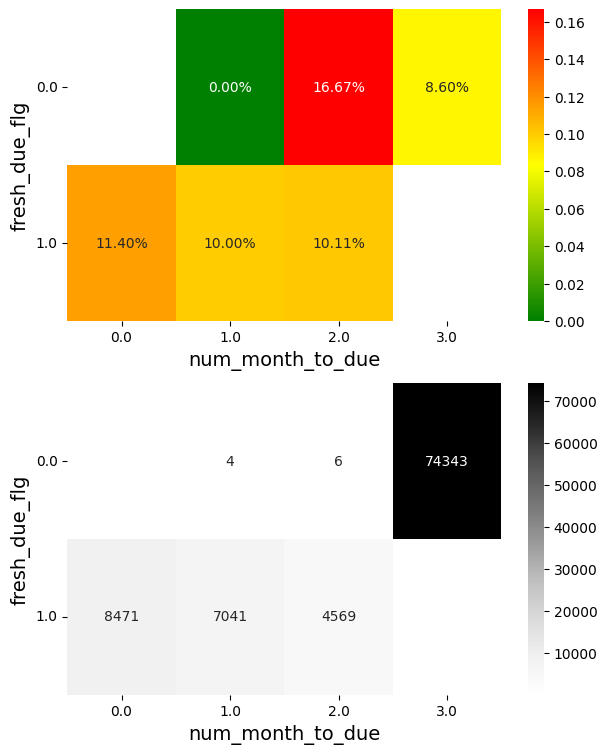

In [51]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['fresh_due_flg'],
    var_2=df.loc[df.sample_part == 'Train']['num_month_to_due'],
    target='d4p12',
    name_1='fresh_due_flg',
    name_2='num_month_to_due',
    nbuck_1=5,
    nbuck_2=5,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)

feature_names.remove('fresh_due_flg')

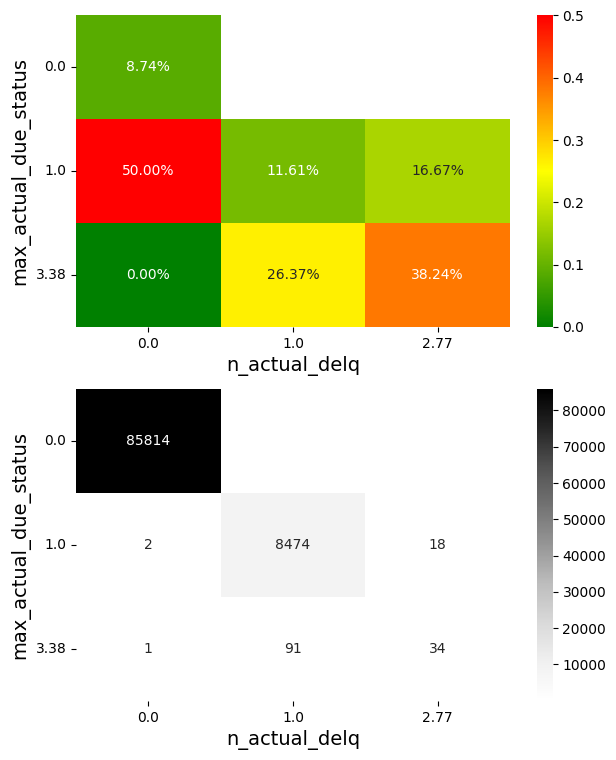

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
 Wrong objects for 3: total 2, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
 Wrong objects for 4: total 1, target 0
 Wrong objects for 7: total 1, target 0
 Wrong objects for 9: total 1, target 1
 Wrong objects for 13: total 1, target 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [58]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['max_actual_due_status'],
    var_2=df.loc[df.sample_part == 'Train']['n_actual_delq'],
    target='d4p12',
    name_1='max_actual_due_status',
    name_2='n_actual_delq',
    nbuck_1=3,
    nbuck_2=3,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)

res1 = woe_line(
    var=df.loc[df.sample_part == 'Train']['max_actual_due_status'],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='max_actual_due_status',
    target_nm='d4p12',
    plot_line=False,
    plot_hist=False
)
res2 = woe_line(
    var=df.loc[df.sample_part == 'Train']['n_actual_delq'],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='n_actual_delq',
    target_nm='d4p12',
    plot_line=False,
    plot_hist=False
)
if res1['IV'] > res2['IV']:
  feature_names.remove('n_actual_delq')
else:
  feature_names.remove('max_actual_due_status')

In [59]:
feature_names

['due_chance',
 'due_chance_v02',
 'balance_sum',
 'mfo_flg',
 'num_fresh_mfo',
 'num_status_no_due',
 'num_closed_credits',
 'outstanding_rate',
 'num_month_to_due',
 'payments_6month_part',
 'outstanding_raise',
 'max_due_status_4_month',
 'max_actual_due_status',
 'credits_with_due_rate',
 'worst_dlq_cd',
 'ccr_utilization_rate',
 'mortgage_flg',
 'outstanding_raise_ccr',
 'avg_ann_repay_amt',
 'gender_cd',
 'marital_status_cd',
 'education_level_cd',
 'work_exp_cd',
 'car_own_flg',
 'region_rating',
 'job_type_cd',
 'debet_score',
 'num_rejected_appl',
 'bki_score',
 'partner1_score',
 'partner2_score',
 'telecom1_score',
 'telecom2_score']

# Optuna objective

**Задание 0**

**Выделите набор признаков и таргет для обучения бустингов в отдельные `DataFrame` по частям выборки. Результат запишите в `(X_train, y_train), (X_val, y_val), (X_test, y_test)`.**

In [60]:
X_train, y_train = df[df.sample_part == 'Train'][feature_names], df[df.sample_part == 'Train']['d4p12']
X_val, y_val = df[df.sample_part == 'Validation'][feature_names], df[df.sample_part == 'Validation']['d4p12']
X_test, y_test = df[df.sample_part == 'Test'][feature_names], df[df.sample_part == 'Test']['d4p12']

In [62]:
import optuna

**Задание 1**

**Реализуйте штраф к `AUC` на валидационной выборке. Штраф должен присваиваться переменной `diff_score`.** \
**Логика штрафа:**

Штрафуем, если разница метрик на трейне и валидации больше, чем не штрафуемая разница (`affordable_diff`), иначе штраф `0`.

**Вычисление штрафа:**

1. Считаем насколько разница метрик выше не штрафуемого порога.
2. Возводим величину в квадрат.
3. Умножаем на масштаб (`scale`) и на `1e4`

In [85]:
def metric(
    auc_train,
    auc_val,
    affordable_diff=0.01,
    scale = 0.01
    ):
    
    '''
    affordable_diff: не штрафуемая разница, 
                    можно, например, взять разницу для линейной модели, которая склонна к переобучению
    scale: за сколько AUC готовы простить разницу на 0.01 выше порога
    '''

    metric_diff = np.abs(auc_val - auc_train)
    if metric_diff > affordable_diff:
      diff_score = metric_diff**2 * scale * 1e4
    else: 
      diff_score = 0
    
    return auc_val - diff_score
 
def objective(trial):
    param = {
        'reg_lambda':trial.suggest_float('reg_lambda', 1e-1, 100, log=True), # Можем указать логшкалу
        'reg_alpha':trial.suggest_float('reg_alpha', 1e-1, 100, log=True),
        'num_leaves':trial.suggest_int('num_leaves', 20, 50), # Для целочисленных аналогично, но через функцию suggest_int
        'learning_rate':trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),        
        'n_estimators': trial.suggest_int('n_estimators', 900, 1200),
        'n_jobs': 4,
        'random_state': 4242
     }

    clf = LGBMClassifier(**param)
 
    clf.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_val, y_val)],
            eval_metric='auc',
            callbacks = [
                lgb.early_stopping(stopping_rounds=150, first_metric_only=True)
            ]
        )
    
    auc_val = clf.evals_result_['valid_1']['auc'][-1]
    auc_train = clf.evals_result_['training']['auc'][-1]
    
    # возвращаем метрики которые хотим оптимизировать
    return metric(auc_train, auc_val)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=400)


print(len(study.trials))
print('best trial')
trial = study.best_trial
 
print("Value: {}".format(trial.value))
print( 'Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2023-05-05 18:57:41,387] A new study created in memory with name: no-name-fdd6542c-9560-4f78-b74b-876f9c022a53
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 150 rounds


[I 2023-05-05 18:58:27,389] Trial 0 finished with value: -0.20914159299277724 and parameters: {'reg_lambda': 32.83979310933918, 'reg_alpha': 0.45964377830004194, 'num_leaves': 39, 'learning_rate': 0.026713985850662668, 'n_estimators': 957}. Best is trial 0 with value: -0.20914159299277724.


Early stopping, best iteration is:
[313]	training's auc: 0.802791	training's binary_logloss: 0.263662	valid_1's auc: 0.72096	valid_1's binary_logloss: 0.26398
Evaluated only: auc


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[936]	training's auc: 0.750198	training's binary_logloss: 0.285323	valid_1's auc: 0.702129	valid_1's binary_logloss: 0.26967
Evaluated only: auc


[I 2023-05-05 18:59:47,878] Trial 1 finished with value: 0.47106764269499235 and parameters: {'reg_lambda': 5.221701236623768, 'reg_alpha': 76.9825957222902, 'num_leaves': 27, 'learning_rate': 0.002754638023686391, 'n_estimators': 936}. Best is trial 1 with value: 0.47106764269499235.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[1077]	training's auc: 0.786887	training's binary_logloss: 0.269981	valid_1's auc: 0.716936	valid_1's binary_logloss: 0.264893
Evaluated only: auc


[I 2023-05-05 19:01:36,245] Trial 2 finished with value: 0.22762221012955502 and parameters: {'reg_lambda': 10.807726471434654, 'reg_alpha': 0.21191444861854325, 'num_leaves': 38, 'learning_rate': 0.004249585095328588, 'n_estimators': 1077}. Best is trial 1 with value: 0.47106764269499235.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 150 rounds


[I 2023-05-05 19:02:06,955] Trial 3 finished with value: -0.6118522045660881 and parameters: {'reg_lambda': 18.705332837557318, 'reg_alpha': 4.008458376811579, 'num_leaves': 36, 'learning_rate': 0.055522616734821006, 'n_estimators': 932}. Best is trial 1 with value: 0.47106764269499235.


Early stopping, best iteration is:
[208]	training's auc: 0.810526	training's binary_logloss: 0.260555	valid_1's auc: 0.721588	valid_1's binary_logloss: 0.263926
Evaluated only: auc


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[690]	training's auc: 0.803681	training's binary_logloss: 0.263486	valid_1's auc: 0.718746	valid_1's binary_logloss: 0.264442
Evaluated only: auc


[I 2023-05-05 19:03:17,250] Trial 4 finished with value: -0.15399705974739875 and parameters: {'reg_lambda': 2.520389695570999, 'reg_alpha': 1.331886939506993, 'num_leaves': 33, 'learning_rate': 0.011415293855312078, 'n_estimators': 1001}. Best is trial 1 with value: 0.47106764269499235.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[931]	training's auc: 0.745962	training's binary_logloss: 0.290661	valid_1's auc: 0.695581	valid_1's binary_logloss: 0.273501
Evaluated only: auc


[I 2023-05-05 19:04:41,131] Trial 5 finished with value: 0.44175540131081636 and parameters: {'reg_lambda': 0.5743807471466205, 'reg_alpha': 8.121657476601365, 'num_leaves': 34, 'learning_rate': 0.0011719282761400393, 'n_estimators': 931}. Best is trial 1 with value: 0.47106764269499235.


6
best trial
Value: 0.47106764269499235
Params: 
reg_lambda: 5.221701236623768
reg_alpha: 76.9825957222902
num_leaves: 27
learning_rate: 0.002754638023686391
n_estimators: 936


# Построение модели

**Основное задание**

**Постройте собственную модель градиентного бустинга, подобрав оптимальные гиперпараметры. Можно использовать любые признаки из датасета.**

* Критерии успешного выполнения
 - `ROC AUC` модели превосходит 0.759 на `Test`.
 - Нарисованы кривые накопления `AUC` и `logloss` модели.
 - Выведен `feature importance` модели по `gain`.
 - Проведен анализ стабильности и линейности финальной модели.
 - Проведено сравнение с `вашей` моделью логистической регрессии со 2-го семинара, подобное разобранному на семинаре.

* Дополнительно
 - Есть ли пересечение топа важных признаков?
 - Какие признаки сильнее учтены в бустинге, чем в логреге (высокий importance при низком коэффициенте в модели логистической регрессии/либо не входит в модель логистической регрессии)
 
<font color='red'> Запрещено обучаться и подбирать гиперпараметры на `Test` выборке! </font>

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 400 rounds
[50]	training's auc: 0.719707	training's binary_logloss: 0.312597	valid_1's auc: 0.676235	valid_1's binary_logloss: 0.286405
[100]	training's auc: 0.721657	training's binary_logloss: 0.308598	valid_1's auc: 0.677111	valid_1's binary_logloss: 0.283898
[150]	training's auc: 0.723729	training's binary_logloss: 0.305377	valid_1's auc: 0.680096	valid_1's binary_logloss: 0.281817
[200]	training's auc: 0.72596	training's binary_logloss: 0.302688	valid_1's auc: 0.682498	valid_1's binary_logloss: 0.280097
[250]	training's auc: 0.728176	training's binary_logloss: 0.300406	valid_1's auc: 0.683637	valid_1's binary_logloss: 0.278707
[300]	training's auc: 0.73048	training's binary_logloss: 0.298421	valid_1's auc: 0.685335	valid_1's binary_logloss: 0.277487
[350]	training's auc: 0.732606	training's binary_logloss: 0.296688	valid_1's auc: 0.687396	valid_1's binary_logloss: 0.276389
[400]	training's auc: 0.734742	training's binary_logloss: 0

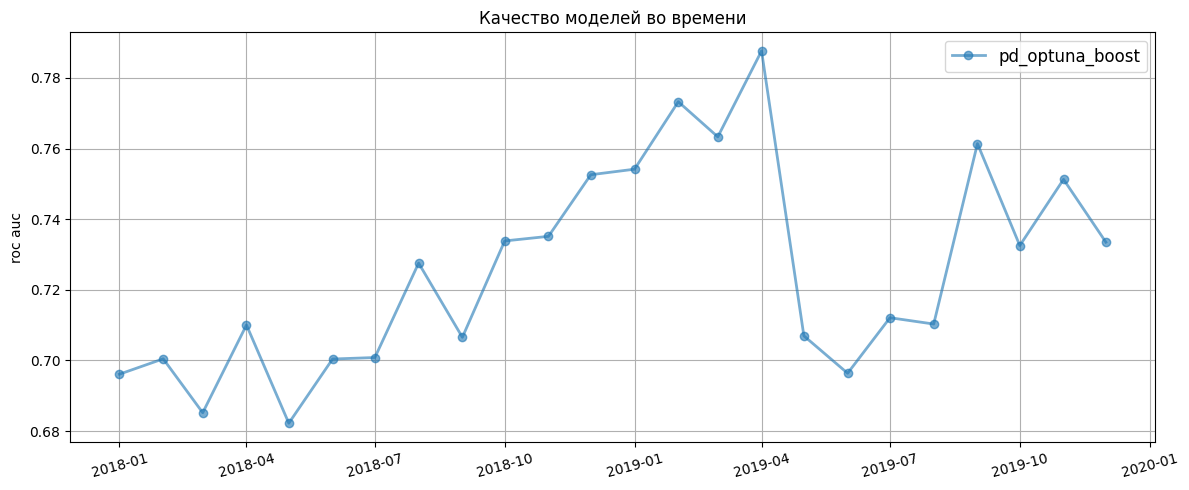

,pd_optuna_boost
2018-01-01,0.696114
2018-02-01,0.700458
2018-03-01,0.685203
2018-04-01,0.710039
2018-05-01,0.682236
2018-06-01,0.700402
2018-07-01,0.700828
2018-08-01,0.727560
2018-09-01,0.706554
2018-10-01,0.733833


In [88]:
best_optuna_params = trial.params
best_optuna_boosting = LGBMClassifier(**best_optuna_params)

best_optuna_boosting.fit(
    X_train, y_train,
    eval_set = [(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks = [
        lgb.early_stopping(stopping_rounds=400, first_metric_only=True),
        lgb.log_evaluation(50)
    ]
)

df['pd_optuna_boost'] = best_optuna_boosting.predict_proba(df[feature_names])[:, 1]

plot_metric_time(
    df=df,
    features=['pd_optuna_boost'],
    target='d4p12',
    time='month_dt',
    ttl='Качество моделей во времени'
)

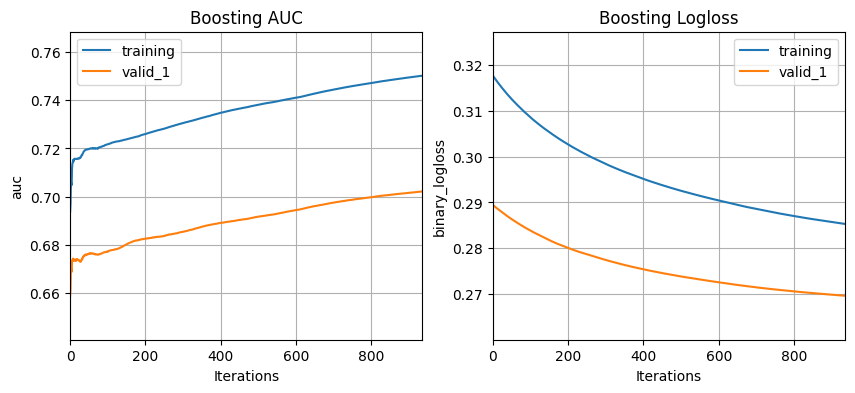

In [87]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

plot_metric(
    best_optuna_boosting,
    metric='auc',
    dataset_names=['training', 'valid_1'],
    ax=ax[0],
    title='Boosting AUC')
plot_metric(
    best_optuna_boosting,
    metric='binary_logloss',
    dataset_names=['training', 'valid_1'],
    ax=ax[1],
    title='Boosting Logloss')
plt.show()

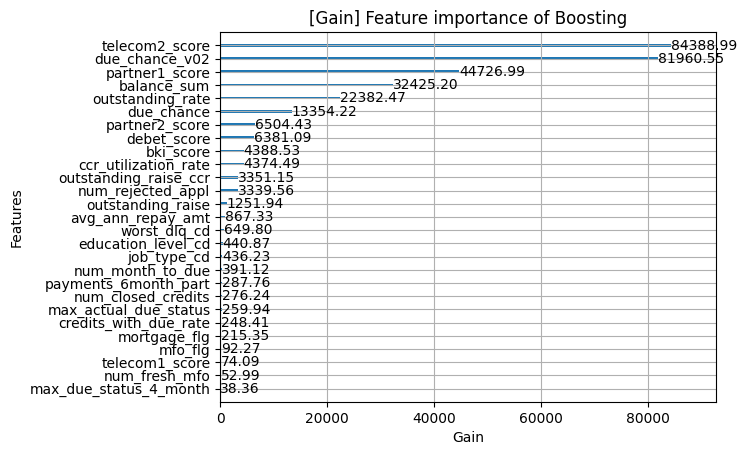

In [67]:
plot_importance(
    best_optuna_boosting,
    title='[Gain] Feature importance of Boosting',
    importance_type='gain',
    xlabel='Gain',
    ylabel='Features',
    grid=True,
    precision=2
)

plt.show()

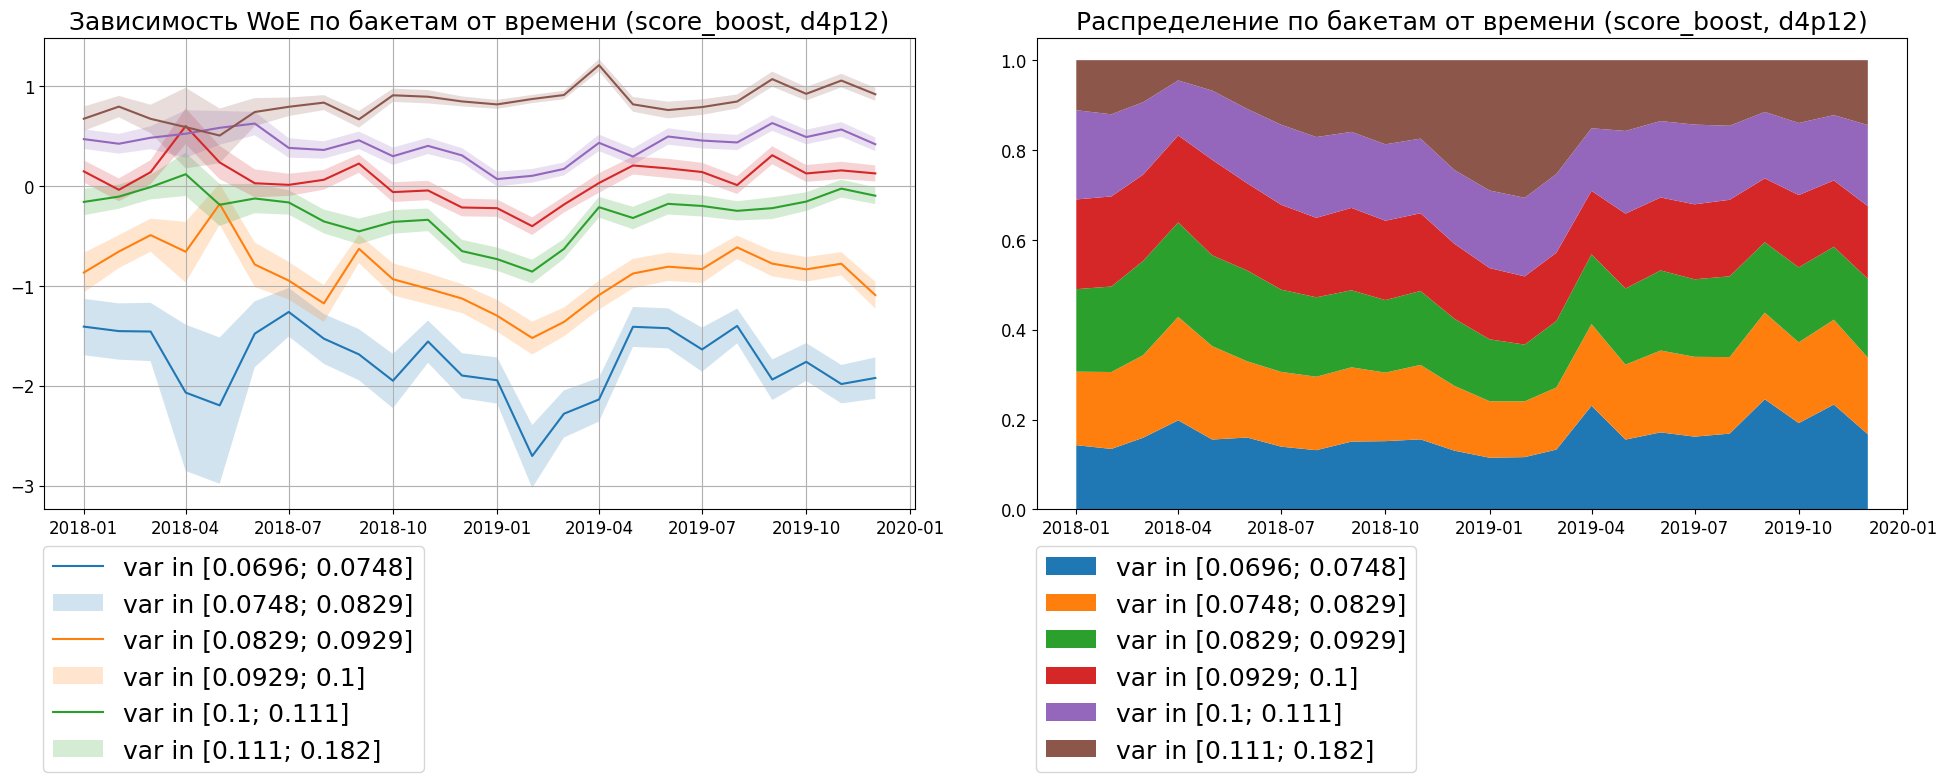

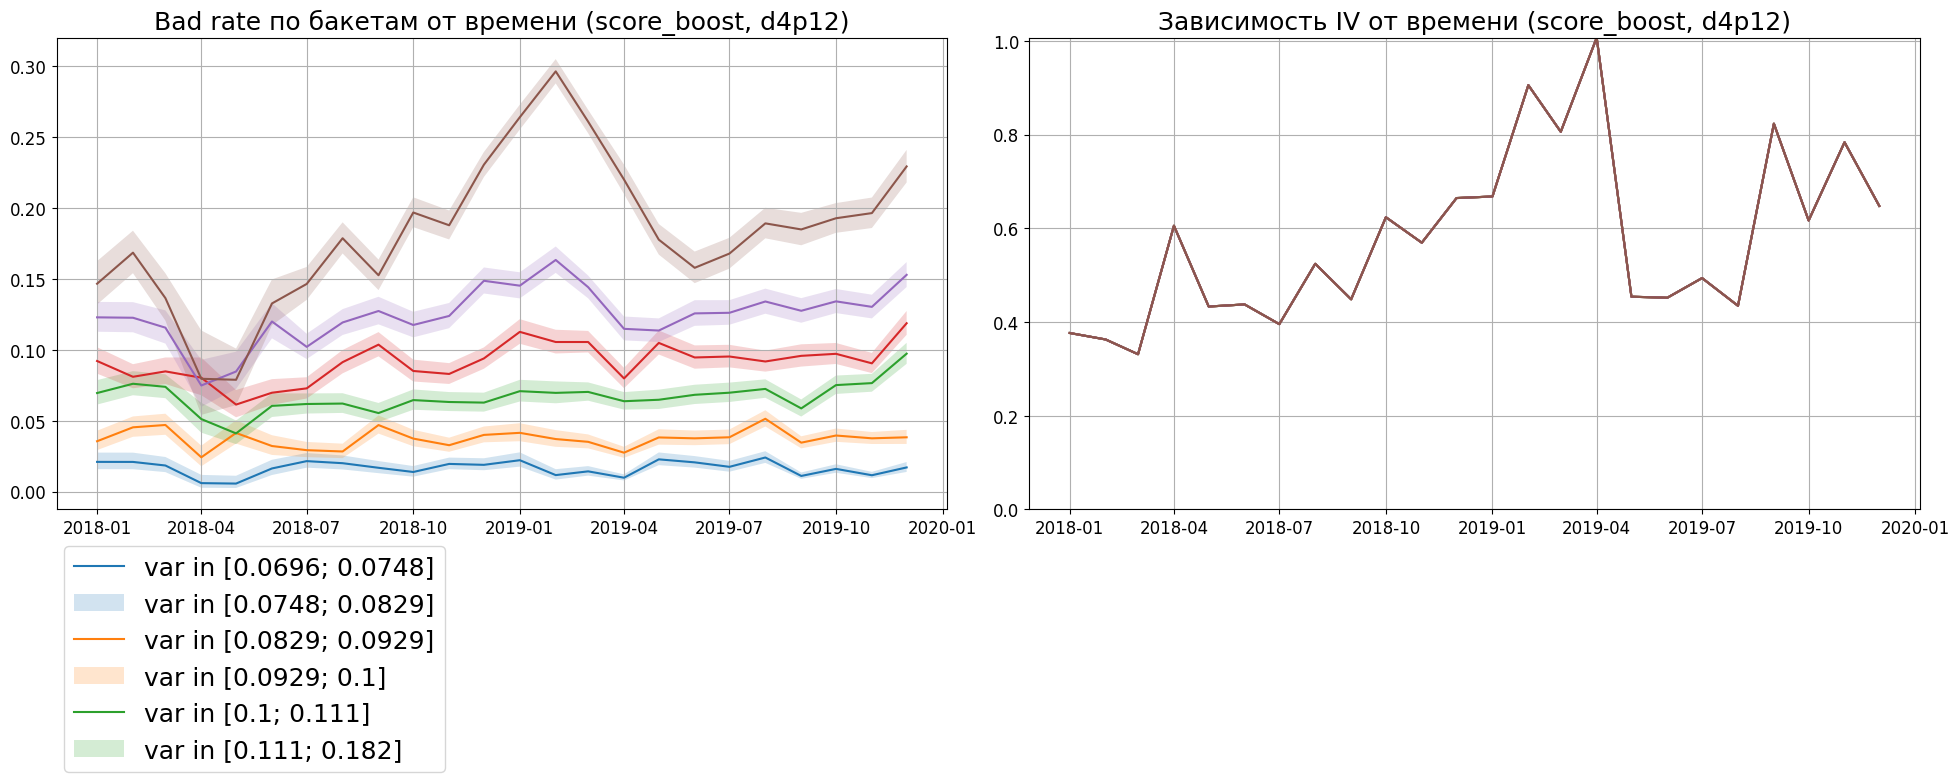

array([0.37657367, 0.36274735, 0.33124021, 0.60552355, 0.43306664,
       0.43755776, 0.39545306, 0.52432331, 0.44850214, 0.62368696,
       0.56929289, 0.66461874, 0.66795071, 0.90557499, 0.80610222,
       1.00693599, 0.45403355, 0.45183683, 0.49381656, 0.43464925,
       0.82337978, 0.61669868, 0.78370823, 0.64781652])

In [68]:
woe_stab(
    var=df['pd_optuna_boost'],
    Nvar=6, # для модели отрисуем побольше бакетов
    time=df['month_dt'],
    bad=df['d4p12'],
    varname='score_boost',
    target='d4p12'
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


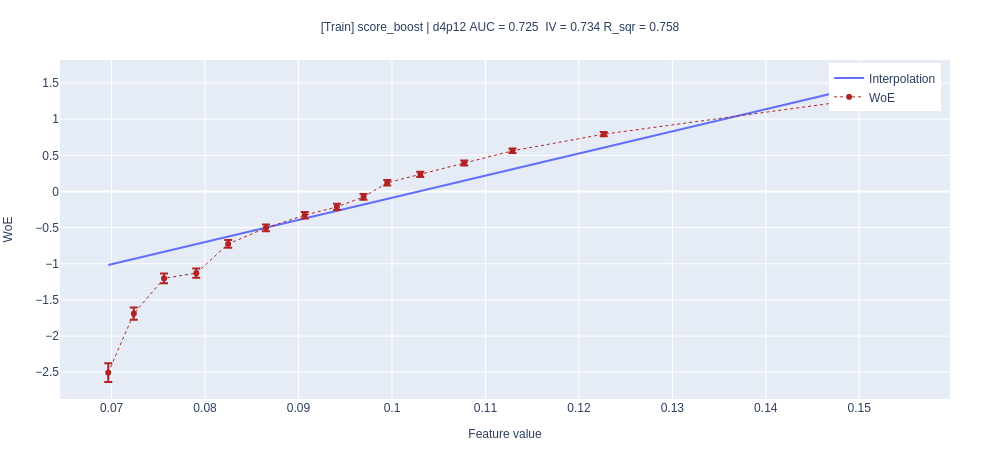

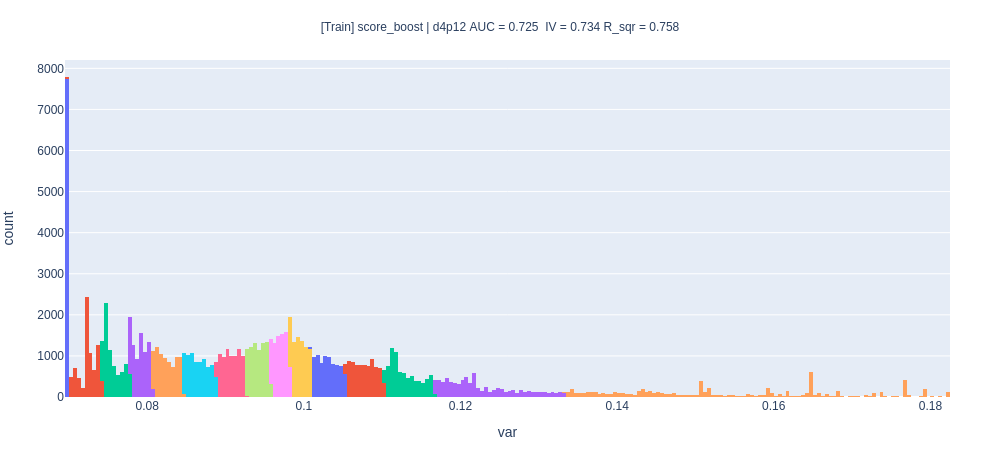

{'AUC': 0.725,
 'IV': 0.734,
 'R_sqr': 0.758,
 'n_obs': 116151,
 'n_buckets': 15,
 'coef': 0.6664397437359673}

In [69]:
woe_line(
    var=df.loc[df.sample_part == 'Train']['pd_optuna_boost'],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='[Train] score_boost',
    target_nm='d4p12',
    plot_hist=True
)

In [93]:
features_num = []

for feature_name in feature_names:
    col_type = df[feature_name].dtype
    if col_type != 'category':
      features_num.append(feature_name)

X_train, y_train = df[df.sample_part == 'Train'][features_num], df[df.sample_part == 'Train']['d4p12']
X_val, y_val = df[df.sample_part == 'Validation'][features_num], df[df.sample_part == 'Validation']['d4p12']
X_test, y_test = df[df.sample_part == 'Test'][features_num], df[df.sample_part == 'Test']['d4p12']

best_optuna_boosting = LGBMClassifier(**best_optuna_params)

best_optuna_boosting.fit(
    X_train, y_train,
    eval_set = [(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks = [
        lgb.early_stopping(stopping_rounds=150, first_metric_only=True),
        lgb.log_evaluation(50)
    ]
)

Training until validation scores don't improve for 150 rounds
[50]	training's auc: 0.719707	training's binary_logloss: 0.312597	valid_1's auc: 0.676235	valid_1's binary_logloss: 0.286405
[100]	training's auc: 0.721634	training's binary_logloss: 0.308599	valid_1's auc: 0.677198	valid_1's binary_logloss: 0.283896
[150]	training's auc: 0.723675	training's binary_logloss: 0.305381	valid_1's auc: 0.680245	valid_1's binary_logloss: 0.281808
[200]	training's auc: 0.725928	training's binary_logloss: 0.302693	valid_1's auc: 0.682853	valid_1's binary_logloss: 0.280081
[250]	training's auc: 0.728091	training's binary_logloss: 0.300416	valid_1's auc: 0.683882	valid_1's binary_logloss: 0.278686
[300]	training's auc: 0.730419	training's binary_logloss: 0.298432	valid_1's auc: 0.68559	valid_1's binary_logloss: 0.277467
[350]	training's auc: 0.732493	training's binary_logloss: 0.296702	valid_1's auc: 0.687591	valid_1's binary_logloss: 0.27637
[400]	training's auc: 0.734542	training's binary_logloss: 0

LGBMClassifier(learning_rate=0.002754638023686391, n_estimators=936,
               num_leaves=27, reg_alpha=76.9825957222902,
               reg_lambda=5.221701236623768)

In [ ]:
# Используем TreeSHAP алгоритм, интегрированный в LightGBM
explainer = shap.TreeExplainer(best_optuna_boosting)
shap_values = explainer.shap_values(df[features_num])

In [ ]:
shap.summary_plot(shap_values[1], df[features_num])

In [ ]:
shap.dependence_plot('telecom2_score', shap_values[1], df[features_num])